In [129]:
# remove stupid fucking warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import IPython.display as ipd
import math
import json
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [130]:
DATASET_PATH = "Audio"
JSON_PATH = "Json\\data.json"
SAMPLE_RATE = 22050
#PREDICT_DATASET_PATH = "Prediction-Audio\\abcdefg.wav"
Predict_JSON_PATH = "Json\\predict.json"

e:


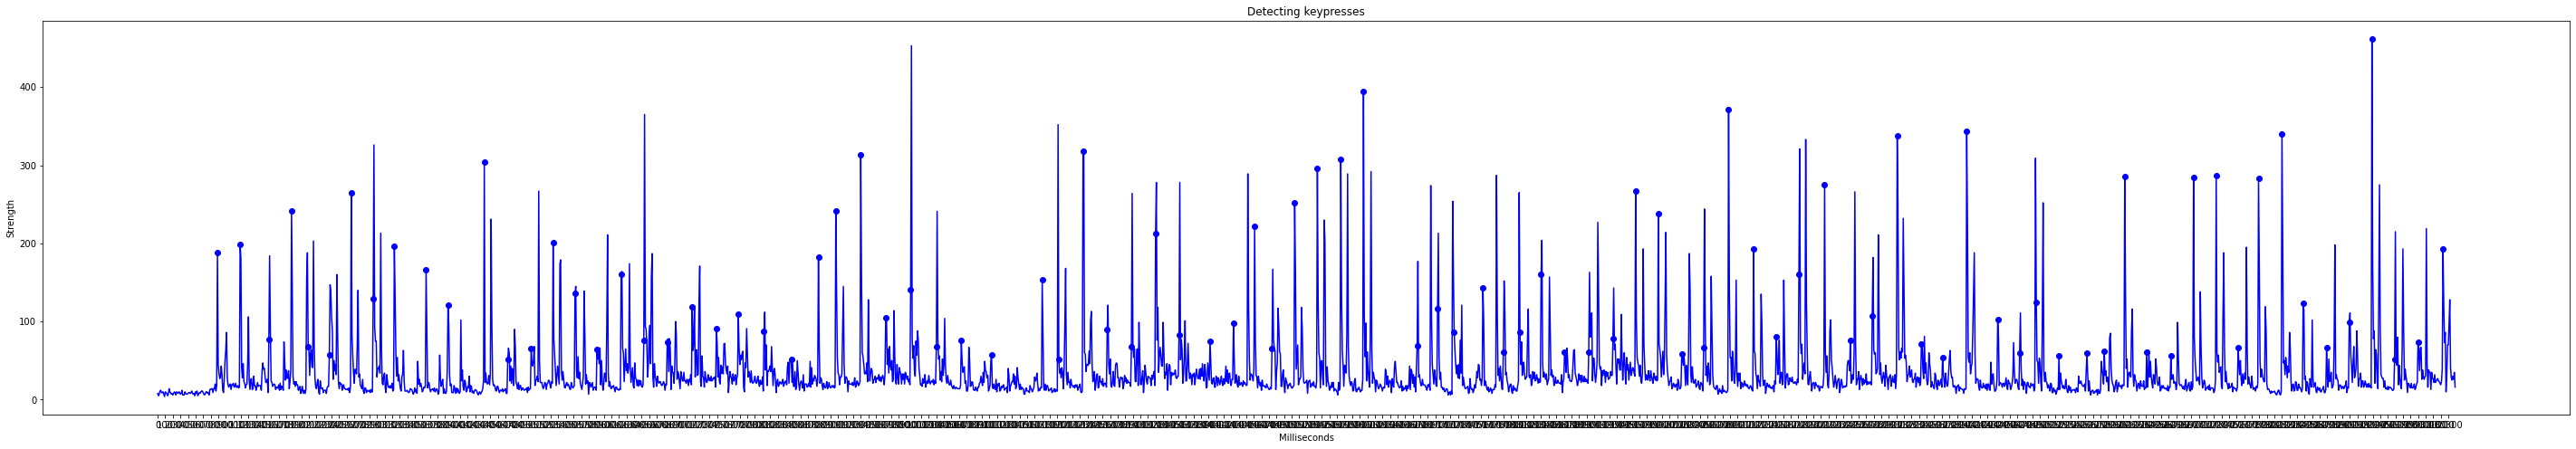

q:


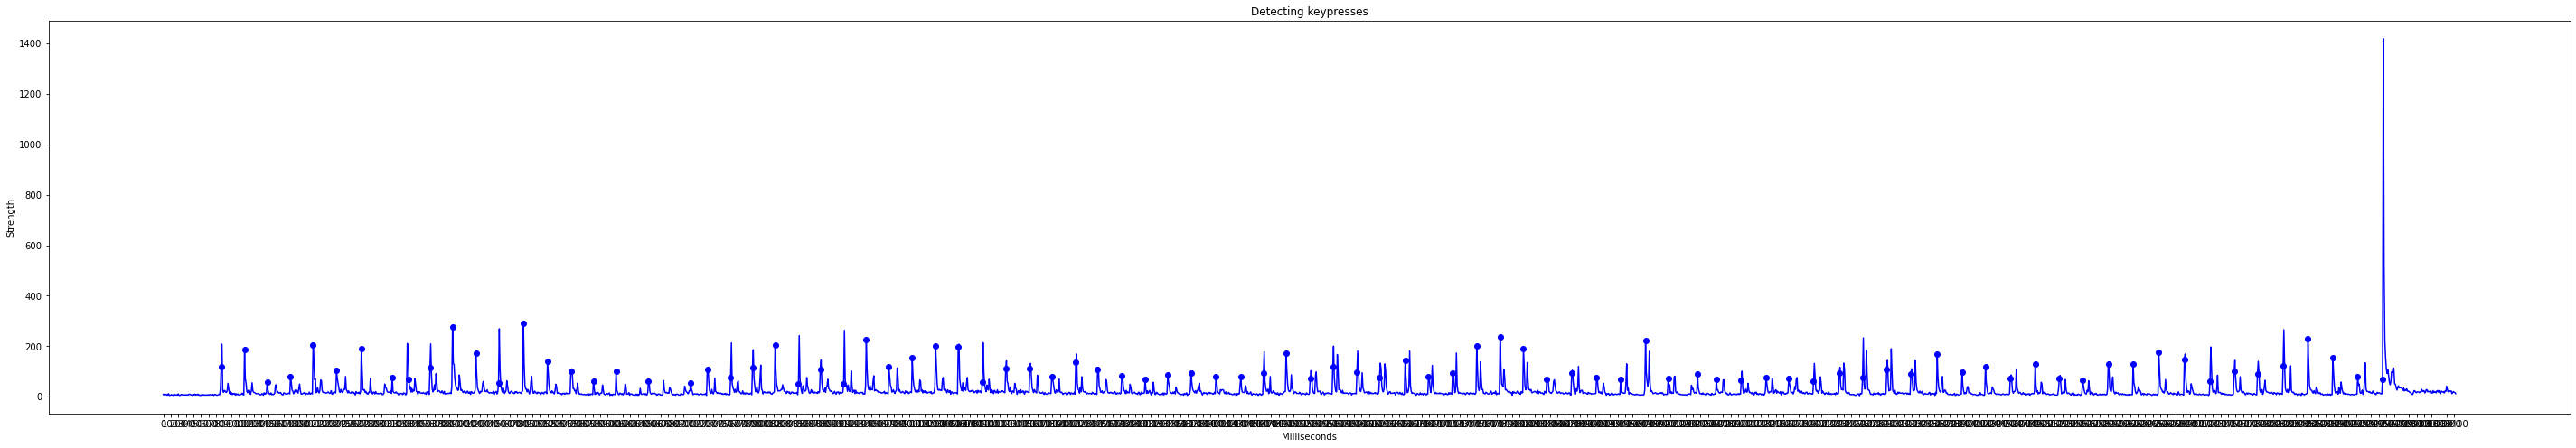

space:


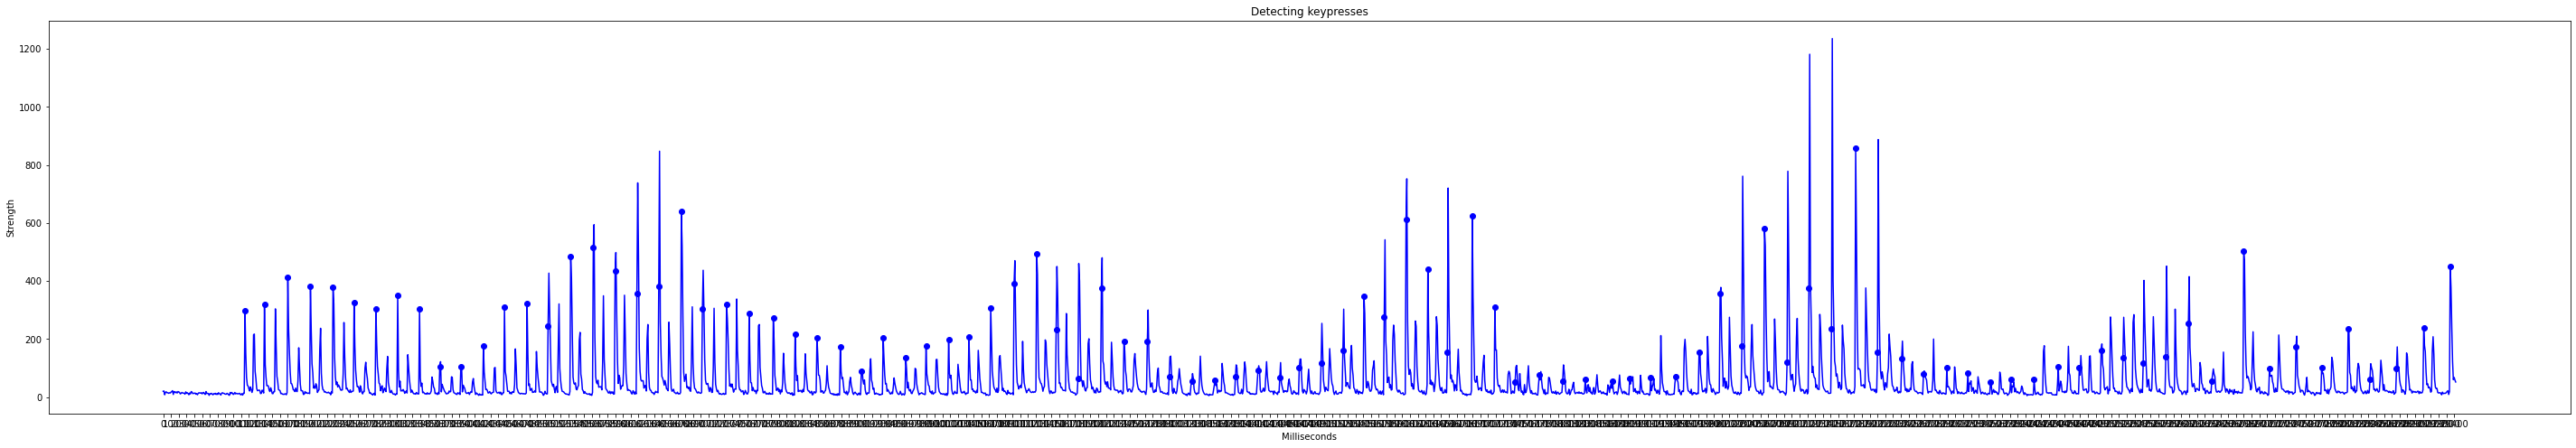

z:


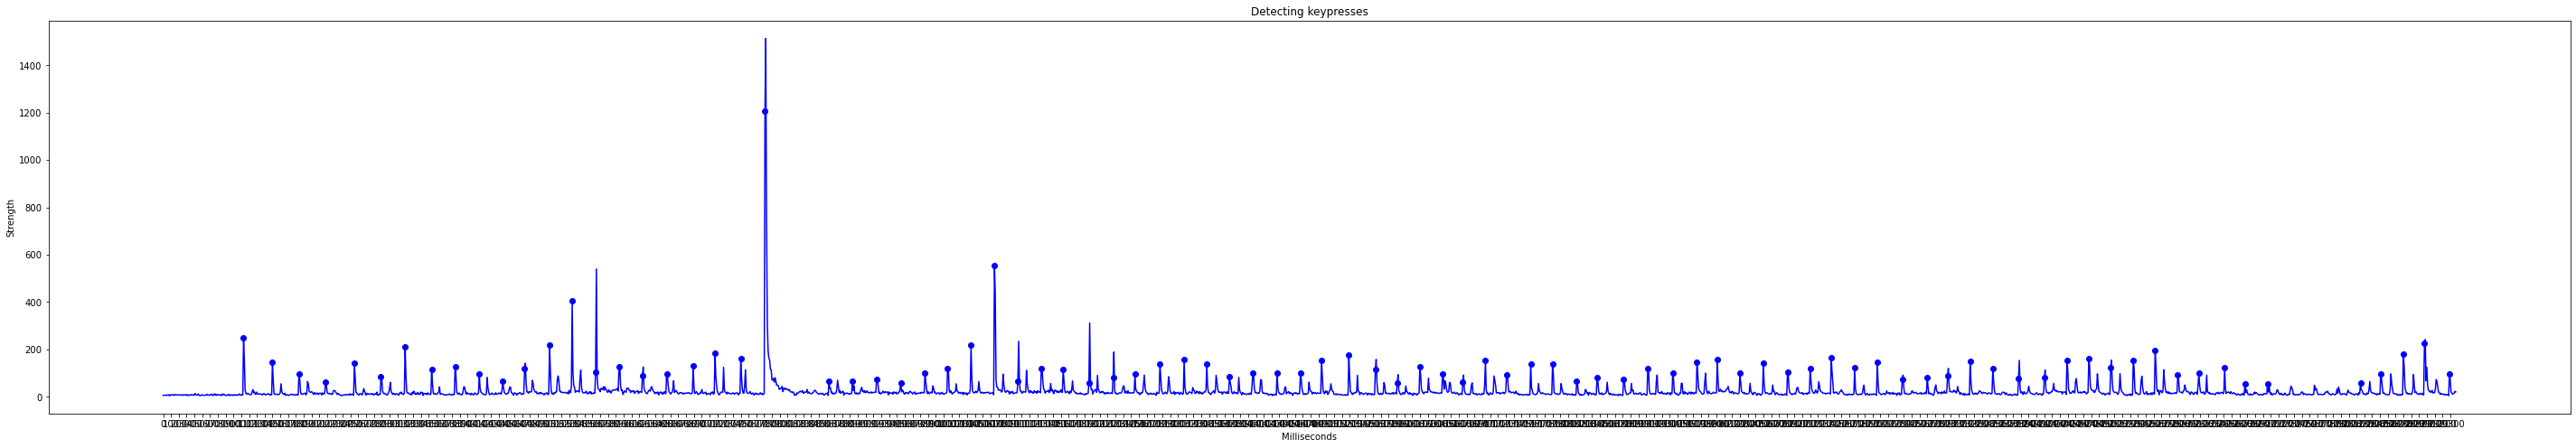

In [133]:
save_data(DATASET_PATH, JSON_PATH)

In [122]:
train_model()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 78)                0         
                                                                 
 dense_75 (Dense)            (None, 400)               31600     
                                                                 
 dense_76 (Dense)            (None, 128)               51328     
                                                                 
 dense_77 (Dense)            (None, 64)                8256      
                                                                 
 dense_78 (Dense)            (None, 4)                 260       
                                                                 
Total params: 91,444
Trainable params: 91,444
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
9/9 [==============================] -

In [127]:
tmp = save_data_to_predict("Prediction-Audio\\test.wav", Predict_JSON_PATH)
data = np.array(tmp["mfcc"])
mapping = load_mapping_for_predict(JSON_PATH)

#Make predictions
predictions = model.predict(data)

predicted_index = np.argmax(predictions, axis=1)
print("predicted index: {} predicted mapping: {}".format(predicted_index, mapping[predicted_index]))

predicted index: [2 2 0 0 1 1] predicted mapping: ['space' 'space' 'e' 'e' 'q' 'q']


<h1>Methods:</h1>

<h2>Getting sum of FFT of a single 10ms segment:</h2>

In [58]:
def fftAndSum(signal):
    
    #Transform waveform into frequency domain using fast Fourier transform
    X = np.fft.fft(signal)
    
    #Get 'loudness' of the 10 ms interval
    X_mag = np.absolute(X)
    sum_of_fft = sum(X_mag)
    return sum_of_fft

<h2>Looping through 10ms segments and getting FFT sums and detecting keypresses:</h2>

In [128]:
def detect_touch_peaks(signal, sr):
    
    # splitting sound into 10 ms chunks
    soundLength = len(signal) / sr # length in seconds
    howManyParts = soundLength * 100 # how many chunks to cut up into
    tenMsParts = np.array_split(signal, howManyParts) # create new array containing 10ms parts
    
    currentTime = 0
    energyArray = []
    detectedClicks = []
    detectedClicksVisualize = [] #Used for plotting FFTs
    ArrayOfMss = []
    passedFirstPeak = False
    detectedKeyPressTime = 0

    for oneSegment in tenMsParts:
        
        ArrayOfMss.append(currentTime) # append current time
        sum_of_fft = round(fftAndSum(oneSegment)) # call fftAndSum and store returned value
        energyArray.append(sum_of_fft)

        #sum_of_fft > (Threshold) which is considered as a peak
        if(sum_of_fft > 50 and not(passedFirstPeak)):
            
            #passedFirstPeak bool is used to skip over the button's release peak when detected the touch peak
            passedFirstPeak = True
            detectedKeyPressTime = currentTime
            
            detectedClicks.append(currentTime) # add time of detected click
            detectedClicksVisualize.append(int(currentTime/10))
            
        elif(currentTime - detectedKeyPressTime > 200): # wait x milliseconds after first peak
            passedFirstPeak = False
            
        currentTime += 10
        
    plt.figure(figsize=(50, 8))
    plt.plot(ArrayOfMss, energyArray, '-bo', markevery = detectedClicksVisualize) # create plot with markers at detected click
    plt.xlabel('Milliseconds')
    plt.xticks(np.arange(0, max(ArrayOfMss),100))
    plt.ylabel('Strength')
    plt.title('Detecting keypresses')

    plt.show() # display plot
    return detectedClicks

<h2>Saving data to JSON for training:</h2>

In [132]:
def save_data(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512):
    #dictionary to store data
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }
    
    #number of mfcc vectors per segment is supposed to be an integer number
    #'0.12' is 120 ms transformed into seconds. 
    #data vectors for the AI are considered on touchPeak-20ms to touchPeak=100ms - 120ms time window
    
    expeceted_number_of_mfcc_vectors_per_segment = math.ceil((SAMPLE_RATE * 0.12)/hop_length)
    
    #Loop through all audio files
    for root, dirnames, filenames in os.walk(DATASET_PATH):         
        
        #i is to label each click in a file with a label (e.g. recording: a a a a a, these all then labeled 0 0 0 0 0)
        for i, (f) in enumerate(filenames):
            
            #Load audio files
            file_path = os.path.join(root, f)
            signal, sr = librosa.load(file_path)
            
            #Label data with semantic labels (mappings)
            semantic_label = f.removesuffix(".wav")
            data["mapping"].append(semantic_label)
            
            print(semantic_label + ":")
            #Find the touch peaks in the audio file
            touch_peaks = detect_touch_peaks(signal, sr)
            
            for peak in touch_peaks:
                
                #Start sample is calculated to start 20ms before the detected touch peak
                #peak(ms)-20(ms) is devided by 1000, to get the time our start_sample started in seconds, not ms
                #time when the sample started * sampleRate gives which sample it is (e.g. 501th sample in waveform)
                start_sample = int(sr * (peak-20)/1000)
                end_sample = int(sr * (peak+100)/1000)
                

                #Extract MFCC features from the signal, but only from the touch peaks (start_sample:finish_sample)
                mfcc = librosa.feature.mfcc(signal[start_sample:end_sample],
                                           sr=sr,
                                           n_fft=n_fft,
                                           n_mfcc=n_mfcc,
                                           hop_length=hop_length)
                #Transpose mfcc
                mfcc = mfcc.T
                
                #store mfcc for segment if it has the expected length
                if(len(mfcc) == expeceted_number_of_mfcc_vectors_per_segment):
                    data["mfcc"].append(mfcc.tolist())
                    data["labels"].append(i)

    #write data into a json file                
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

<h2>Saving data to JSON for prediction:</h2>

In [ ]:
def save_data_to_predict(predict_dataset_file_path, predict_json_path, n_mfcc=13, n_fft=2048, hop_length=512):
    #dictionary to store data
    predict_data = {
        "mfcc": [],
    }
    #number of mfcc vectors per segment is supposed to be an integer number
    expeceted_number_of_mfcc_vectors_per_segment = math.ceil((SAMPLE_RATE * 0.12)/hop_length)
    

    #Load audio file
    signal, sr = librosa.load(predict_dataset_file_path)


    #Find the touch peaks in the audio file
    touch_peaks = detect_touch_peaks(signal, sr)
    
    for peak in touch_peaks:

        #Start sample is calculated to start 20ms before the detected touch peak
        #peak(ms)-20(ms) is devided by 1000, to get the time our start_sample started in seconds, not ms
        #time when the sample started * sampleRate gives which sample it is (e.g. 501th sample in waveform)
        start_sample = int(sr * (peak-20)/1000)
        end_sample = int(sr * (peak+100)/1000)


        #Extract MFCC features from the signal, but only from the touch peaks (start_sample:finish_sample)
        mfcc = librosa.feature.mfcc(signal[start_sample:end_sample],
                                   sr=sr,
                                   n_fft=n_fft,
                                   n_mfcc=n_mfcc,
                                   hop_length=hop_length)
        #Transpose mfcc
        mfcc = mfcc.T

        #store mfcc for segment if it has the expected length
        if(len(mfcc) == expeceted_number_of_mfcc_vectors_per_segment):
            predict_data["mfcc"].append(mfcc.tolist())

    with open(predict_json_path, "w") as fp:
        json.dump(predict_data, fp, indent=4)
    return predict_data

<h2>Loading data for training:</h2>

In [ ]:
def load_data(json_dataset_path):
    with open(json_dataset_path, "r") as fp:
        data = json.load(fp)
        
    #Convert lists into np arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])
    
    return inputs, targets

<h2>Loading the mappings for prediction:</h2>

In [126]:
def load_mapping_for_predict(JSON_PATH):
    with open(JSON_PATH, "r") as jp:
        data_for_maping = json.load(jp)
    mapping = np.array(data_for_maping["mapping"])
    return mapping

<h2>Training the model:</h2>

In [121]:
def train_model():
    #Load data
    inputs, targets = load_data(JSON_PATH)

    #Split data into train and test sets
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs,
                                                                             targets,
                                                                             test_size=0.3)
    #Building NN architecture
    model = keras.Sequential([

        #Input layer
        #Flatten inputs into a 1D array
        #[0] - segments of audio [1] - intervals within segments, [2] - mfcc values for those intervals
        keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])), 

        #1st hidden layer
        keras.layers.Dense(400, activation="relu"),

        #2nd hidden layer
        keras.layers.Dense(128, activation="relu"),

        #2nd hidden layer
        keras.layers.Dense(64, activation="relu"),

        #Output layer
        keras.layers.Dense(4, activation="softmax")
    ])
    #Compile NN
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer,
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

    model.summary()

    #Train NN

    model.fit(inputs_train, targets_train, validation_data=(inputs_test, targets_test), epochs=50, batch_size=32)

    